In [1]:
!pip install fsspec
!pip install gcsfs
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 8.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 9.9 MB/s 
     |████████████████████████████████| 94 kB 4.8 MB/s 
     |████████████████████████████████| 271 kB 52.1 MB/s 
     |████████████████████████████████| 144 kB 73.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.6 MB/s 
     |████████████████████████████████| 596 kB 63.5 MB/s 
     |████████████████████████████████| 6.6 MB 47.5 MB/s 
     |████████████████████████████████| 101 kB 13.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/Colab Notebooks/tfm"
import sys
sys.path.append('tfm/checkpoints/')
sys.path.append('tfm/outputs/')

Mounted at /content/drive


In [3]:
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tqdm.auto import tqdm
from transformers import (
    AutoTokenizer,
    TFBertForSequenceClassification,
)

In [4]:
filepath = "../../data/outputs/dataset_2021_paragraph"
filepath = "https://storage.googleapis.com/tfm_aideas_datasets/dataset_2021_paragraph" # Filepath GCloud
filepath = "tfm/outputs/dataset_2021_paragraph" # Filepath COLAB

In [6]:
df_total_labels = pd.read_csv(f"{filepath}_annotated.csv", sep=";", index_col=0, parse_dates=["date"], low_memory=False)

In [7]:
finance_label = df_total_labels.finanzas_tag_s_n.isin([0, 1])
dataset_labels = df_total_labels[finance_label]
dataset_unlabelled = df_total_labels[~finance_label]

In [8]:
dataset_opt = Dataset.from_pandas(df_total_labels.loc[~finance_label,["body_no_entities","vola_label"]])

In [9]:
# Para no entrenar varias veces con los mismos párrafos debido a que hayan sido asignados
# a diferentes tickers
dataset_labels.drop_duplicates(subset=["body"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [10]:
dataset_labels.finanzas_tag_s_n.value_counts()/sum(dataset_labels.finanzas_tag_s_n.value_counts())

1.0    0.856215
0.0    0.143785
Name: finanzas_tag_s_n, dtype: float64

A continuación se reentrena únicamente la última capa del modelo BETO para esta tarea de clasificación.

In [11]:
N_LABELS = len(np.unique(dataset_labels.finanzas_tag_s_n))

In [12]:
checkpoint = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/310 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [13]:
model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels=N_LABELS)

Downloading:   0%|          | 0.00/512M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model.layers[0].trainable=False

In [15]:
model.compile(
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
optimizer=Adam(learning_rate=0.0001),
metrics=['accuracy']
)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(dataset_labels.body_no_entities, dataset_labels.finanzas_tag_s_n, test_size=0.2, random_state=42)

In [17]:
x_train = tokenizer(x_train.tolist(), padding="max_length", truncation=True, return_tensors="tf")

In [18]:
x_test = tokenizer(x_test.tolist(), padding="max_length", truncation=True, return_tensors="tf")

In [19]:
N_EPOCAS = 150

In [20]:
# filepath_checkpoint = './checkpoints/finanzas_tag_s_n/checkpoint'
filepath_checkpoint = 'tfm/checkpoints/finanzas_tag_s_n/checkpoint' # Filepath COLAB

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=filepath_checkpoint,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')

hist = model.fit(
    dict(x_train),
    y_train,
    batch_size=128,
    epochs=N_EPOCAS,
    validation_split=0.1,
    callbacks=[model_checkpoint_callback, early_stopping]
    )

Epoch 1/150
13/13 [==============================] - 64s 4s/step - loss: 0.5907 - accuracy: 0.8246 - val_loss: 0.5428 - val_accuracy: 0.8382
Epoch 2/150
13/13 [==============================] - 44s 3s/step - loss: 0.5136 - accuracy: 0.8582 - val_loss: 0.4947 - val_accuracy: 0.8382
Epoch 3/150
13/13 [==============================] - 44s 3s/step - loss: 0.4688 - accuracy: 0.8601 - val_loss: 0.4690 - val_accuracy: 0.8382
Epoch 4/150
13/13 [==============================] - 44s 3s/step - loss: 0.4411 - accuracy: 0.8601 - val_loss: 0.4557 - val_accuracy: 0.8382
Epoch 5/150
13/13 [==============================] - 44s 3s/step - loss: 0.4284 - accuracy: 0.8594 - val_loss: 0.4481 - val_accuracy: 0.8382
Epoch 6/150
13/13 [==============================] - 44s 3s/step - loss: 0.4187 - accuracy: 0.8601 - val_loss: 0.4423 - val_accuracy: 0.8382
Epoch 7/150
13/13 [==============================] - 44s 3s/step - loss: 0.4114 - accuracy: 0.8601 - val_loss: 0.4374 - val_accuracy: 0.8382
Epoch 8/150
1

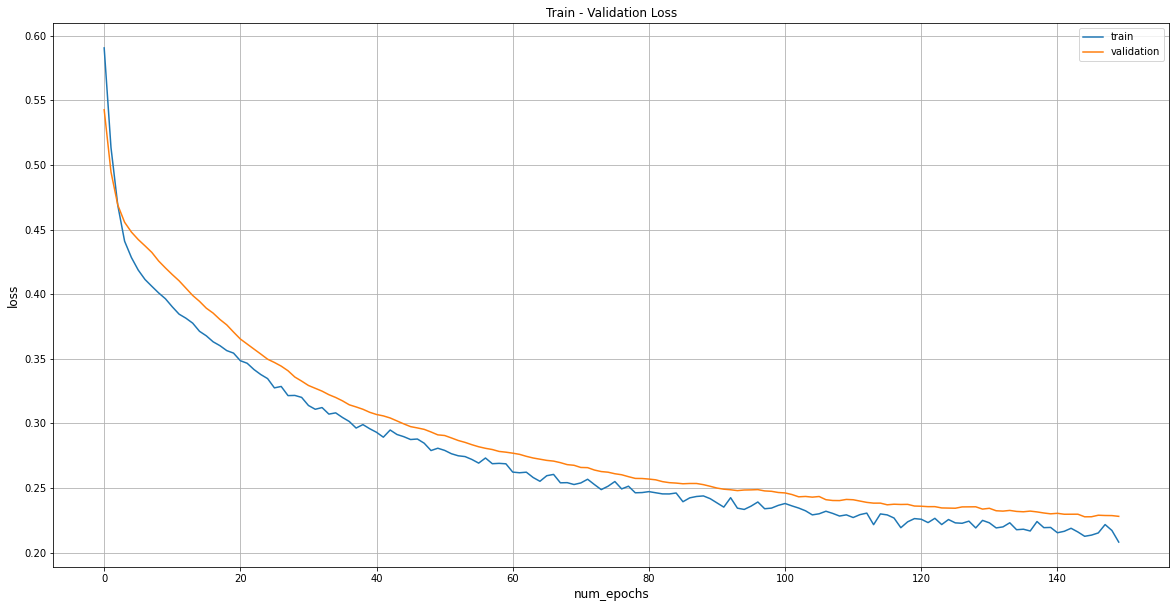

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

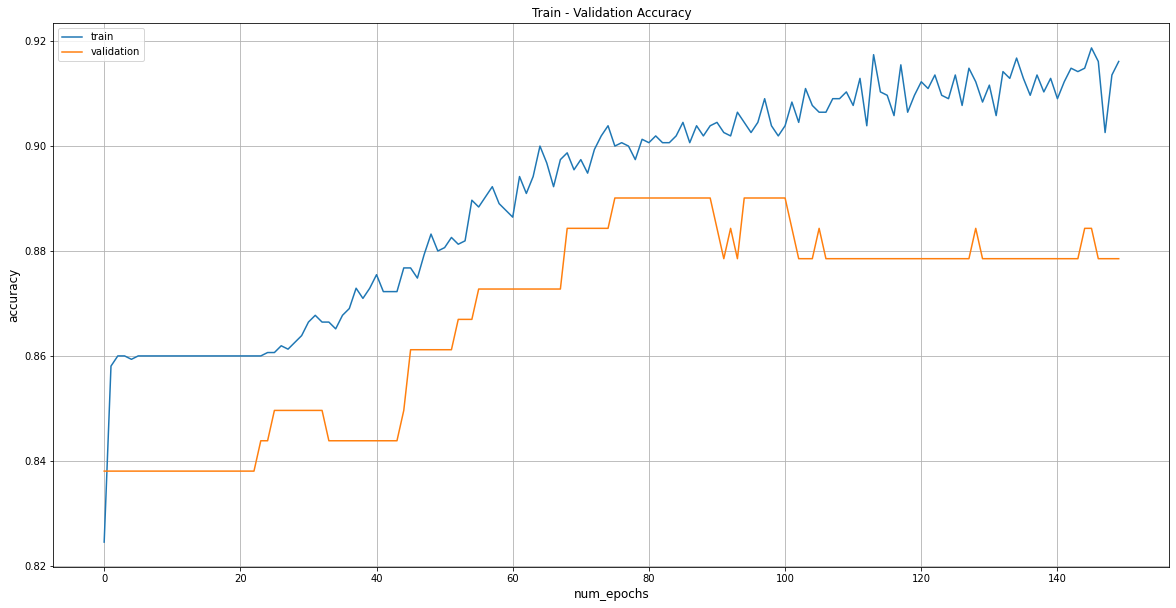

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

In [21]:
model.load_weights(filepath_checkpoint)
model.evaluate(x_test.data, y_test)

14/14 [==============================] - 19s 716ms/step - loss: 0.2160 - accuracy: 0.9144


[0.21596935391426086, 0.9143518805503845]

In [22]:
# Comparativa con una predicción por clase mayoritaria de train:

pd.Series(y_train).value_counts()/sum(pd.Series(y_train).value_counts())

1.0    0.857889
0.0    0.142111
Name: finanzas_tag_s_n, dtype: float64

In [47]:
y_predictions_train = model.predict(x_train.data)

In [48]:
train_posprob = tf.nn.softmax(y_predictions_train.logits).numpy()[:,0]

In [49]:
train_fpr, train_tpr, train_thr = roc_curve(y_train, train_posprob, pos_label=0)

In [50]:
y_predictions_test = model.predict(x_test.data)

In [51]:
test_posprob = tf.nn.softmax(y_predictions_test.logits).numpy()[:,0]

In [52]:
test_fpr, test_tpr, test_thr = roc_curve(y_test, test_posprob, pos_label=0)

' Tanto en train como en test el algoritmo aprende bastante bien porque está alejado de la aleatoriedad.\nLo normal es que el conjunto de train generalice y en test se comporta un poco peor, pero es lo esperable.\n'

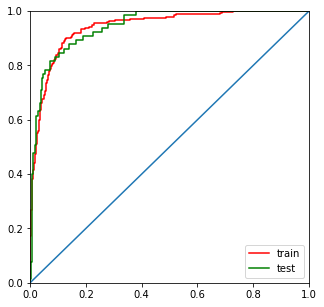

In [53]:
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(train_fpr, train_tpr, color='r', label='train')
plt.plot(test_fpr, test_tpr, color='g', label='test')

plt.plot([0,1],[0,1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.0])
plt.legend(loc='lower right')
plt.show()

In [ ]:
y_pred = y_predictions_test.logits.argmax(axis=1)

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.81      0.45      0.57        65
         1.0       0.91      0.98      0.94       367

    accuracy                           0.90       432
   macro avg       0.86      0.71      0.76       432
weighted avg       0.89      0.90      0.89       432



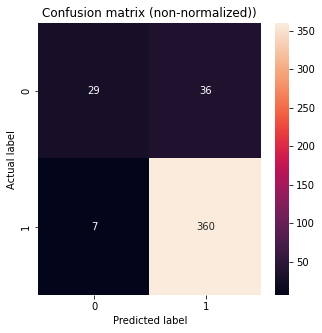

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_test, y_pred)

In [ ]:
def encode(input):
    return tokenizer(input["body_no_entities"], padding="max_length", truncation=True)

In [ ]:
tokenized_dataset = dataset_opt.map(encode, batched=True)
tf_tokenized_dataset = tokenized_dataset.remove_columns(["pk", "body_no_entities",  "vola_label"])
tf_tokenized_dataset.set_format(type='tensorflow', columns=['input_ids', 'token_type_ids', 'attention_mask'])

Parameter 'function'=<function encode at 0x7f5e66062320> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/495 [00:00<?, ?ba/s]

In [ ]:
results = model.predict(tf_tokenized_dataset.to_tf_dataset(batch_size=256), verbose=1)

In [ ]:
df_total_labels["finanzas_tag_s_proba"] = np.NaN
df_total_labels.loc[finance_label, "finanzas_tag_s_proba"] = df_total_labels.loc[finance_label, "finanzas_tag_s_n"].replace({0.0:2.0}).replace({1.0:0.0}).replace({2.0:1.0})
df_total_labels["finanzas_tag_s_n_confianza"] = np.NaN
df_total_labels.loc[finance_label, "finanzas_tag_s_n_confianza"] = 1.
df_total_labels.loc[~finance_label, 'finanzas_tag_s_n'] = results.logits.argmax(axis=1)
df_total_labels.loc[~finance_label, 'finanzas_tag_s_proba'] = tf.nn.softmax(results.logits).numpy()[:,0]
df_total_labels.loc[~finance_label, 'finanzas_tag_s_n_confianza'] = tf.nn.softmax(results.logits).numpy().max(axis=1)

In [ ]:
df_total_labels.to_csv(f'{filepath}_predict_finanzas_tag_s_n.csv', sep=";")

# Transfer Learning con BETO con KFold

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 1...
Epoch 1/70
55/55 [==============================] - 79s 1s/step - loss: 0.5492 - accuracy: 0.7950 - val_loss: 0.4815 - val_accuracy: 0.8093
Epoch 2/70
55/55 [==============================] - 51s 922ms/step - loss: 0.4179 - accuracy: 0.8608 - val_loss: 0.4598 - val_accuracy: 0.8093
Epoch 3/70
55/55 [==============================] - 51s 921ms/step - loss: 0.3908 - accuracy: 0.8608 - val_loss: 0.4434 - val_accuracy: 0.8093
Epoch 4/70
55/55 [==============================] - 51s 921ms/step - loss: 0.3744 - accuracy: 0.8608 - val_loss: 0.4232 - val_accuracy: 0.8093
Epoch 5/70
55/55 [==============================] - 51s 920ms/step - loss: 0.3611 - accuracy: 0.8608 - val_loss: 0.4036 - val_accuracy: 0.8093
Epoch 6/70
55/55 [==============================] - 52s 950ms/step - loss: 0.3489 - accuracy: 0.8608 - val_loss: 0.3877 - val_accuracy: 0.8144
Epoch 7/70
55/55 [==============================] - 51s 922ms/step - loss: 0.3351 - accuracy: 0.8620 - val_loss: 0.3719 -

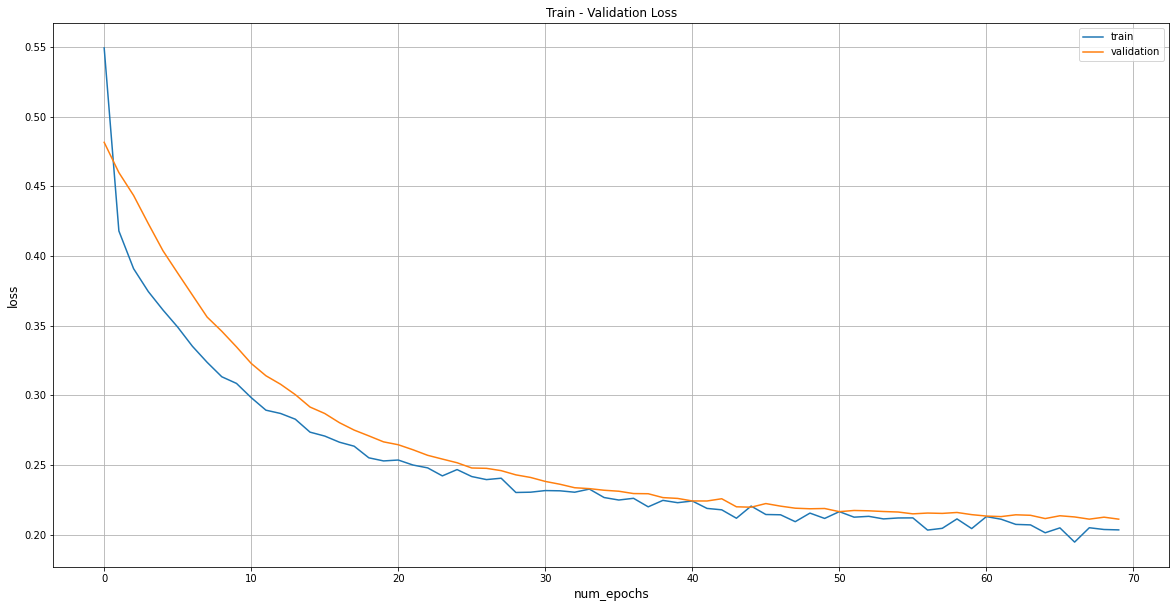

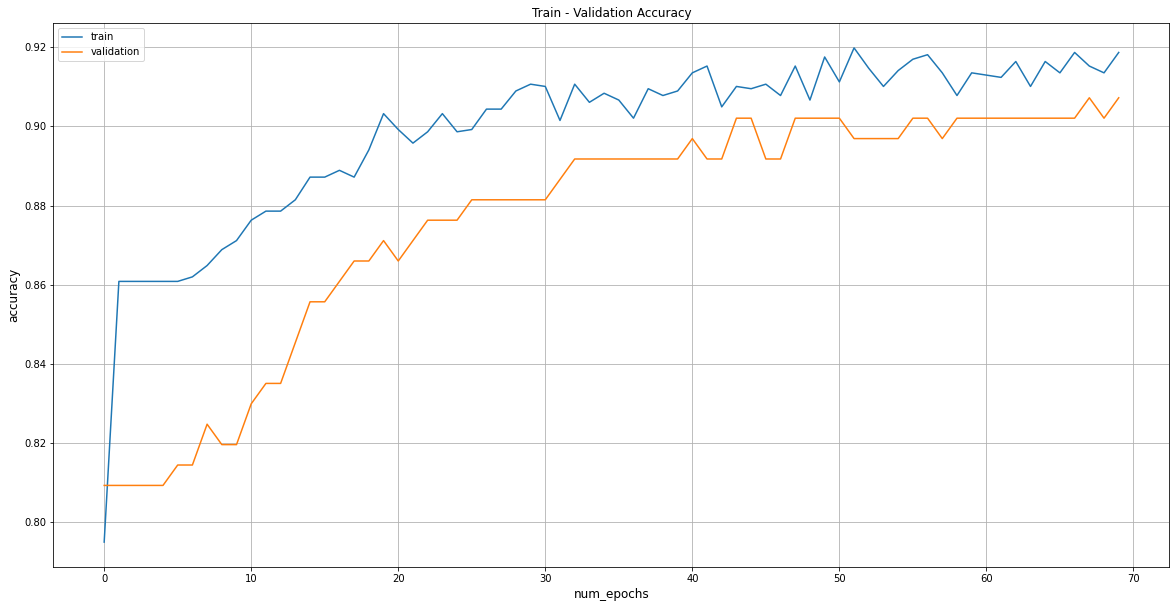

7/7 [==============================] - 5s 714ms/step - loss: 0.2194 - accuracy: 0.9028
Accuracy: 0.9027777910232544


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 2...
Epoch 1/70
55/55 [==============================] - 66s 996ms/step - loss: 0.5623 - accuracy: 0.7743 - val_loss: 0.5212 - val_accuracy: 0.7938
Epoch 2/70
55/55 [==============================] - 51s 920ms/step - loss: 0.4235 - accuracy: 0.8620 - val_loss: 0.5103 - val_accuracy: 0.7938
Epoch 3/70
55/55 [==============================] - 50s 919ms/step - loss: 0.3976 - accuracy: 0.8620 - val_loss: 0.4969 - val_accuracy: 0.7938
Epoch 4/70
55/55 [==============================] - 50s 919ms/step - loss: 0.3824 - accuracy: 0.8620 - val_loss: 0.4732 - val_accuracy: 0.7938
Epoch 5/70
55/55 [==============================] - 50s 920ms/step - loss: 0.3683 - accuracy: 0.8620 - val_loss: 0.4558 - val_accuracy: 0.7938
Epoch 6/70
55/55 [==============================] - 51s 920ms/step - loss: 0.3556 - accuracy: 0.8620 - val_loss: 0.4354 - val_accuracy: 0.7938
Epoch 7/70
55/55 [==============================] - 50s 919ms/step - loss: 0.3434 - accuracy: 0.8620 - val_loss: 0.418

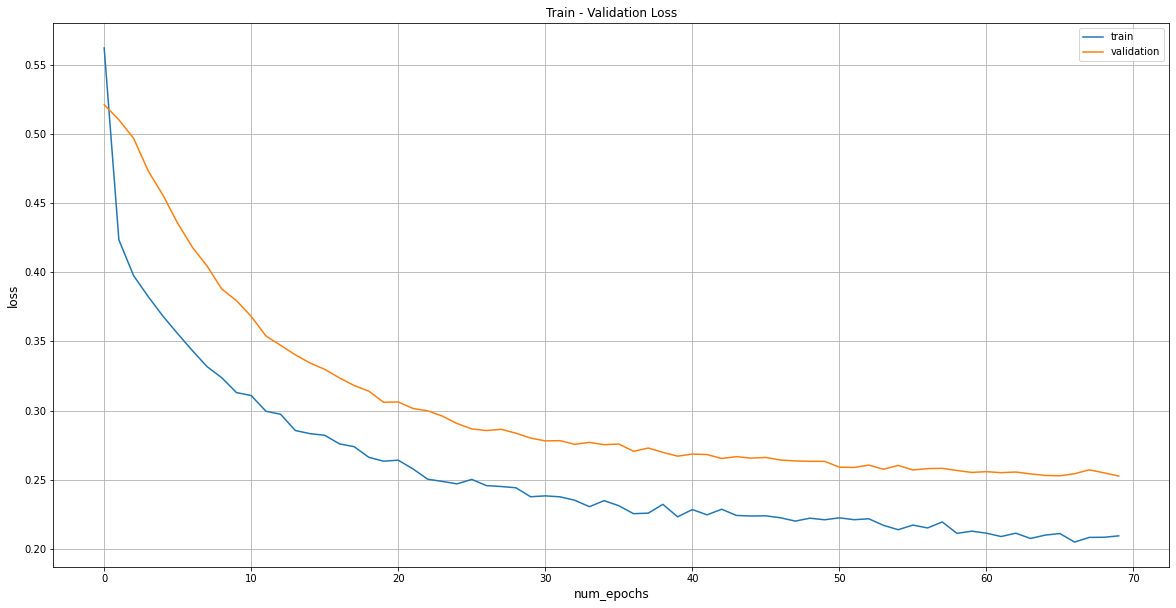

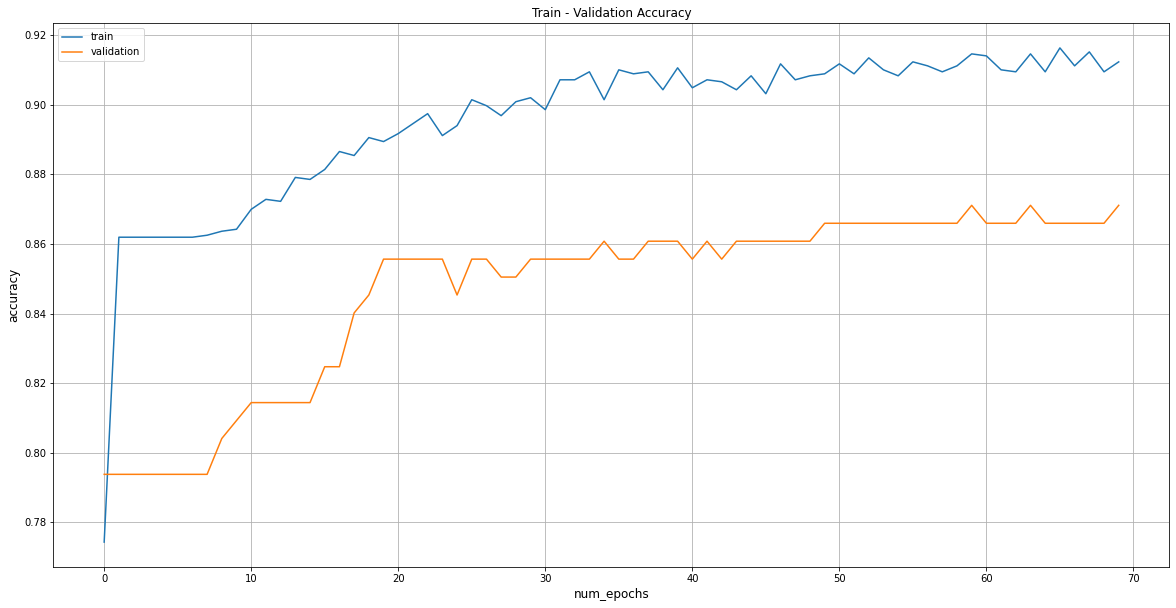

7/7 [==============================] - 5s 713ms/step - loss: 0.2070 - accuracy: 0.9213
Accuracy: 0.9212962985038757


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 3...
Epoch 1/70
55/55 [==============================] - 66s 993ms/step - loss: 0.5497 - accuracy: 0.7858 - val_loss: 0.5075 - val_accuracy: 0.8041
Epoch 2/70
55/55 [==============================] - 51s 921ms/step - loss: 0.4163 - accuracy: 0.8648 - val_loss: 0.4947 - val_accuracy: 0.8041
Epoch 3/70
55/55 [==============================] - 51s 920ms/step - loss: 0.3905 - accuracy: 0.8648 - val_loss: 0.4790 - val_accuracy: 0.8041
Epoch 4/70
55/55 [==============================] - 51s 920ms/step - loss: 0.3736 - accuracy: 0.8648 - val_loss: 0.4585 - val_accuracy: 0.8041
Epoch 5/70
55/55 [==============================] - 51s 920ms/step - loss: 0.3638 - accuracy: 0.8648 - val_loss: 0.4397 - val_accuracy: 0.8041
Epoch 6/70
55/55 [==============================] - 51s 920ms/step - loss: 0.3499 - accuracy: 0.8648 - val_loss: 0.4160 - val_accuracy: 0.8041
Epoch 7/70
55/55 [==============================] - 51s 920ms/step - loss: 0.3390 - accuracy: 0.8648 - val_loss: 0.400

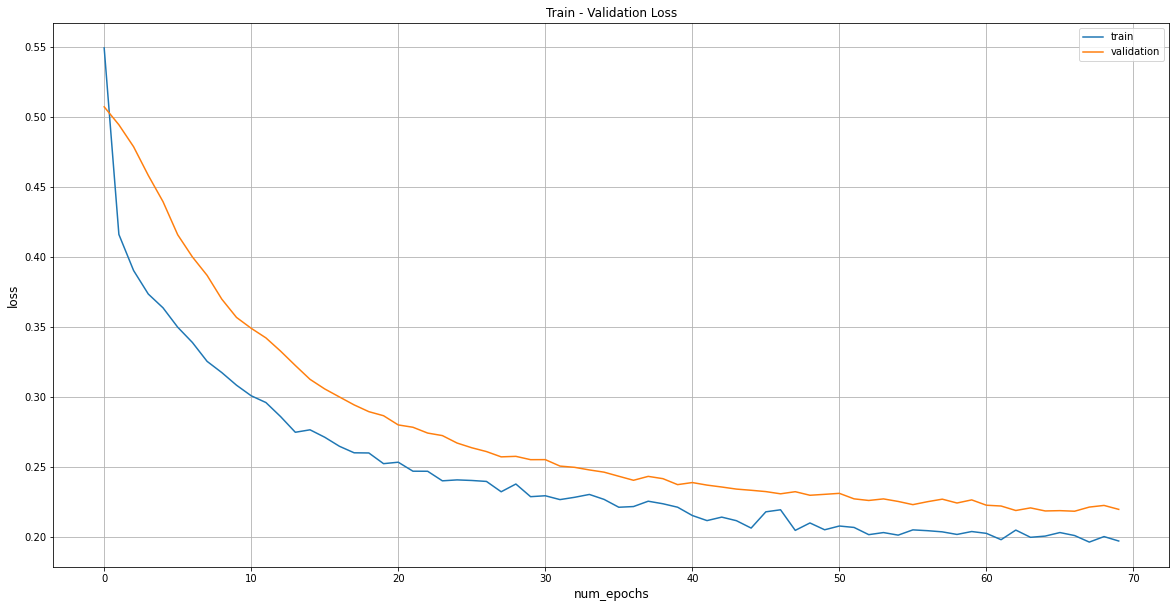

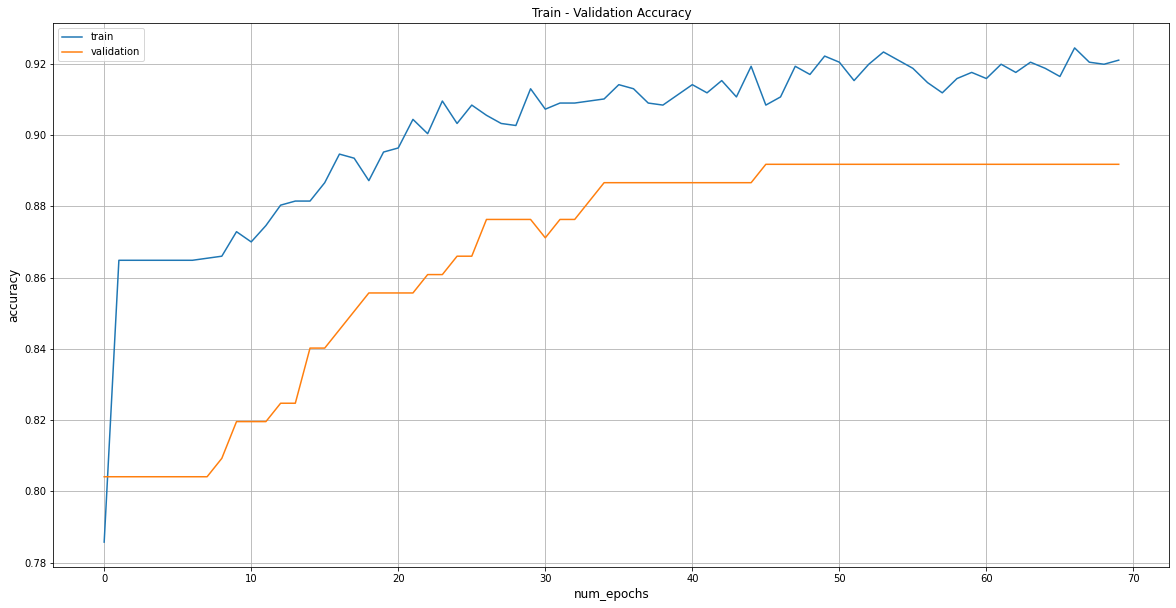

7/7 [==============================] - 5s 713ms/step - loss: 0.3028 - accuracy: 0.8750
Accuracy: 0.875


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 4...
Epoch 1/70
55/55 [==============================] - 66s 1s/step - loss: 0.5188 - accuracy: 0.8414 - val_loss: 0.5035 - val_accuracy: 0.8041
Epoch 2/70
55/55 [==============================] - 51s 921ms/step - loss: 0.4074 - accuracy: 0.8637 - val_loss: 0.4909 - val_accuracy: 0.8041
Epoch 3/70
55/55 [==============================] - 51s 921ms/step - loss: 0.3887 - accuracy: 0.8637 - val_loss: 0.4718 - val_accuracy: 0.8041
Epoch 4/70
55/55 [==============================] - 51s 920ms/step - loss: 0.3732 - accuracy: 0.8637 - val_loss: 0.4498 - val_accuracy: 0.8041
Epoch 5/70
55/55 [==============================] - 51s 921ms/step - loss: 0.3558 - accuracy: 0.8637 - val_loss: 0.4295 - val_accuracy: 0.8041
Epoch 6/70
55/55 [==============================] - 51s 921ms/step - loss: 0.3450 - accuracy: 0.8637 - val_loss: 0.4095 - val_accuracy: 0.8041
Epoch 7/70
55/55 [==============================] - 51s 920ms/step - loss: 0.3320 - accuracy: 0.8637 - val_loss: 0.3913 -

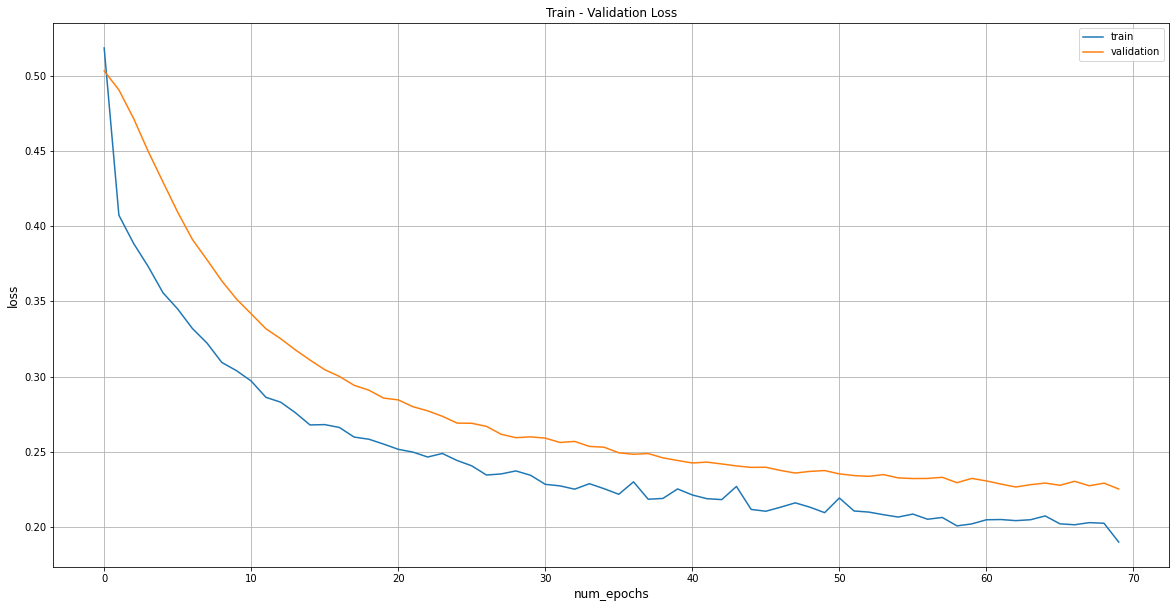

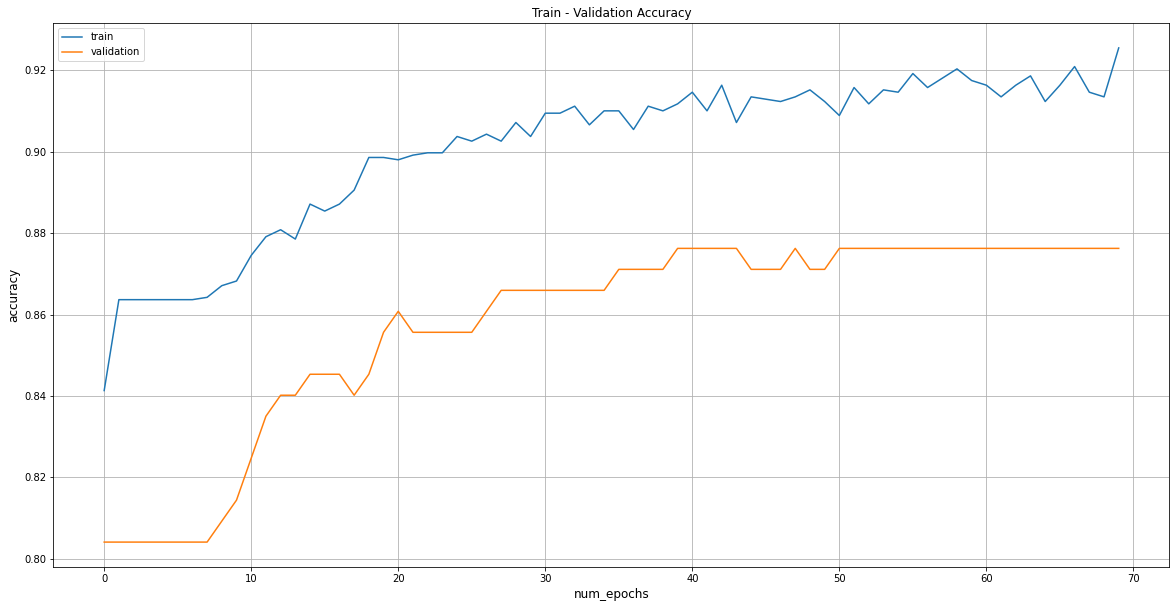

7/7 [==============================] - 5s 715ms/step - loss: 0.2548 - accuracy: 0.8750
Accuracy: 0.875


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 5...
Epoch 1/70
55/55 [==============================] - 67s 1s/step - loss: 0.5682 - accuracy: 0.7658 - val_loss: 0.5222 - val_accuracy: 0.8093
Epoch 2/70
55/55 [==============================] - 51s 922ms/step - loss: 0.4198 - accuracy: 0.8637 - val_loss: 0.5026 - val_accuracy: 0.8093
Epoch 3/70
55/55 [==============================] - 51s 920ms/step - loss: 0.3954 - accuracy: 0.8637 - val_loss: 0.4895 - val_accuracy: 0.8093
Epoch 4/70
55/55 [==============================] - 51s 921ms/step - loss: 0.3795 - accuracy: 0.8637 - val_loss: 0.4680 - val_accuracy: 0.8093
Epoch 5/70
55/55 [==============================] - 51s 921ms/step - loss: 0.3651 - accuracy: 0.8637 - val_loss: 0.4472 - val_accuracy: 0.8093
Epoch 6/70
55/55 [==============================] - 51s 921ms/step - loss: 0.3527 - accuracy: 0.8637 - val_loss: 0.4279 - val_accuracy: 0.8093
Epoch 7/70
55/55 [==============================] - 51s 921ms/step - loss: 0.3411 - accuracy: 0.8637 - val_loss: 0.4151 -

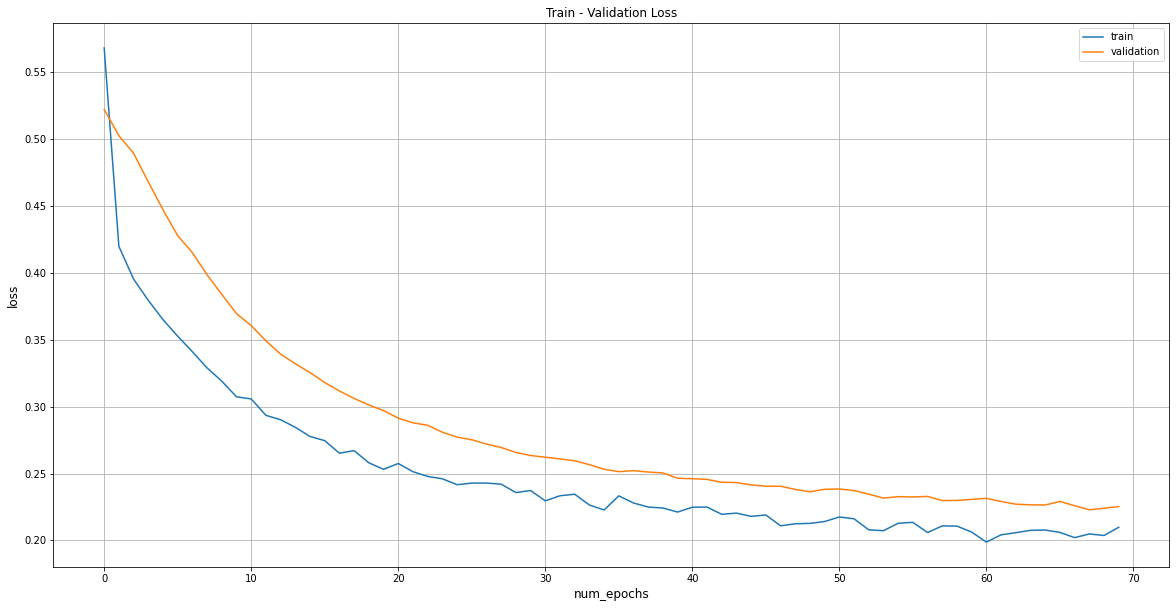

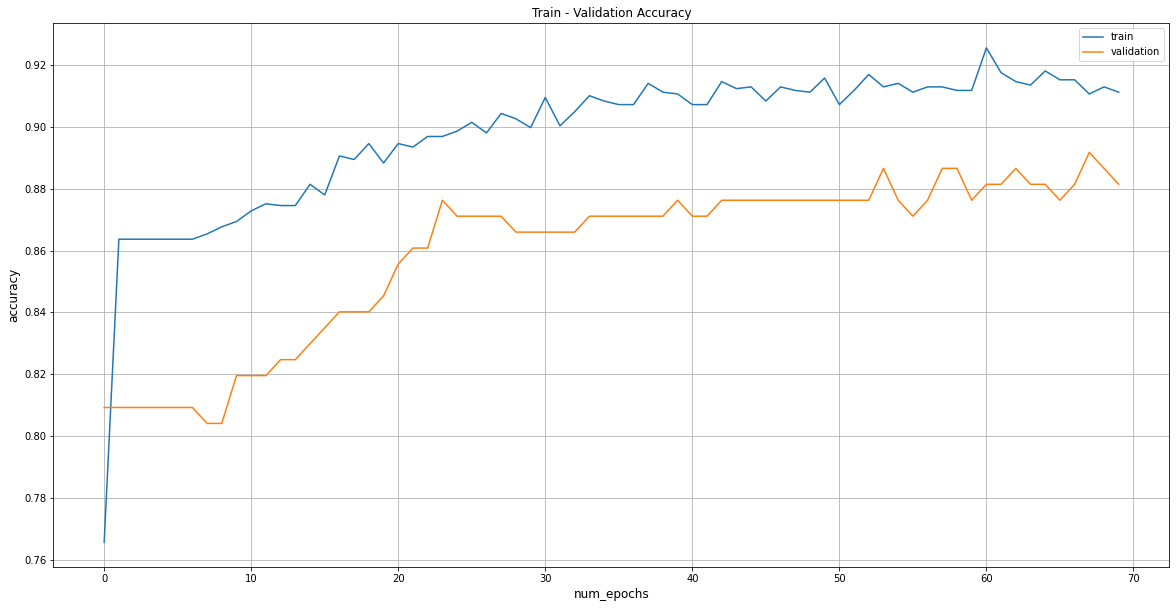

7/7 [==============================] - 5s 716ms/step - loss: 0.2417 - accuracy: 0.8843
Accuracy: 0.8842592835426331


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 6...
Epoch 1/70
55/55 [==============================] - 66s 999ms/step - loss: 0.5360 - accuracy: 0.8156 - val_loss: 0.4730 - val_accuracy: 0.8247
Epoch 2/70
55/55 [==============================] - 51s 923ms/step - loss: 0.4136 - accuracy: 0.8597 - val_loss: 0.4522 - val_accuracy: 0.8247
Epoch 3/70
55/55 [==============================] - 51s 921ms/step - loss: 0.3922 - accuracy: 0.8597 - val_loss: 0.4358 - val_accuracy: 0.8247
Epoch 4/70
55/55 [==============================] - 51s 922ms/step - loss: 0.3763 - accuracy: 0.8597 - val_loss: 0.4164 - val_accuracy: 0.8247
Epoch 5/70
55/55 [==============================] - 51s 921ms/step - loss: 0.3611 - accuracy: 0.8597 - val_loss: 0.4005 - val_accuracy: 0.8247
Epoch 6/70
55/55 [==============================] - 51s 922ms/step - loss: 0.3527 - accuracy: 0.8597 - val_loss: 0.3839 - val_accuracy: 0.8247
Epoch 7/70
55/55 [==============================] - 53s 958ms/step - loss: 0.3395 - accuracy: 0.8603 - val_loss: 0.370

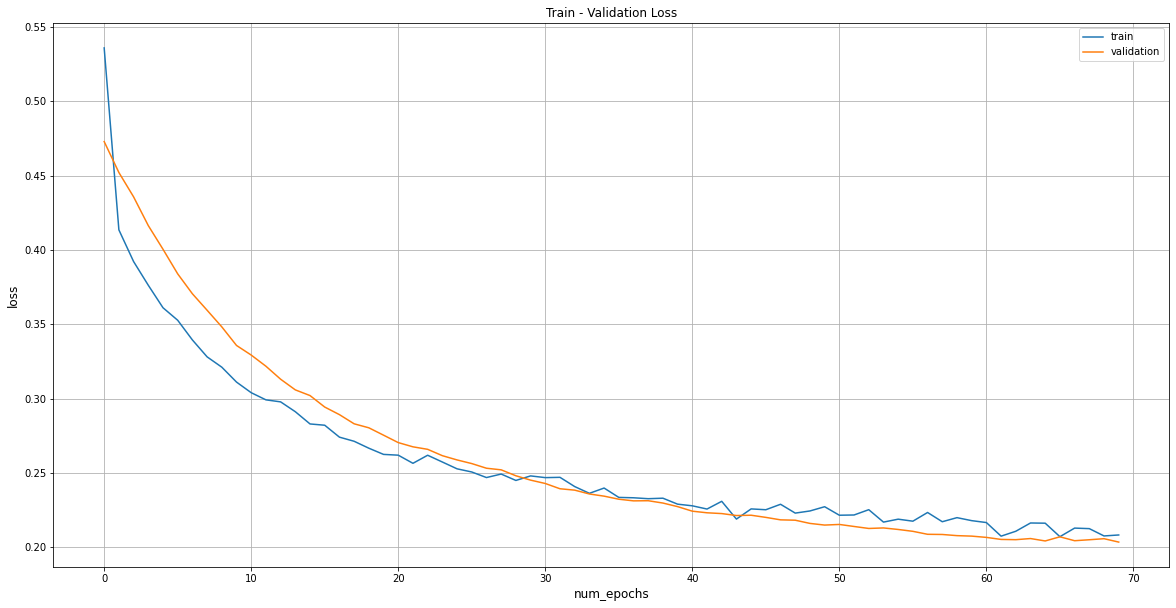

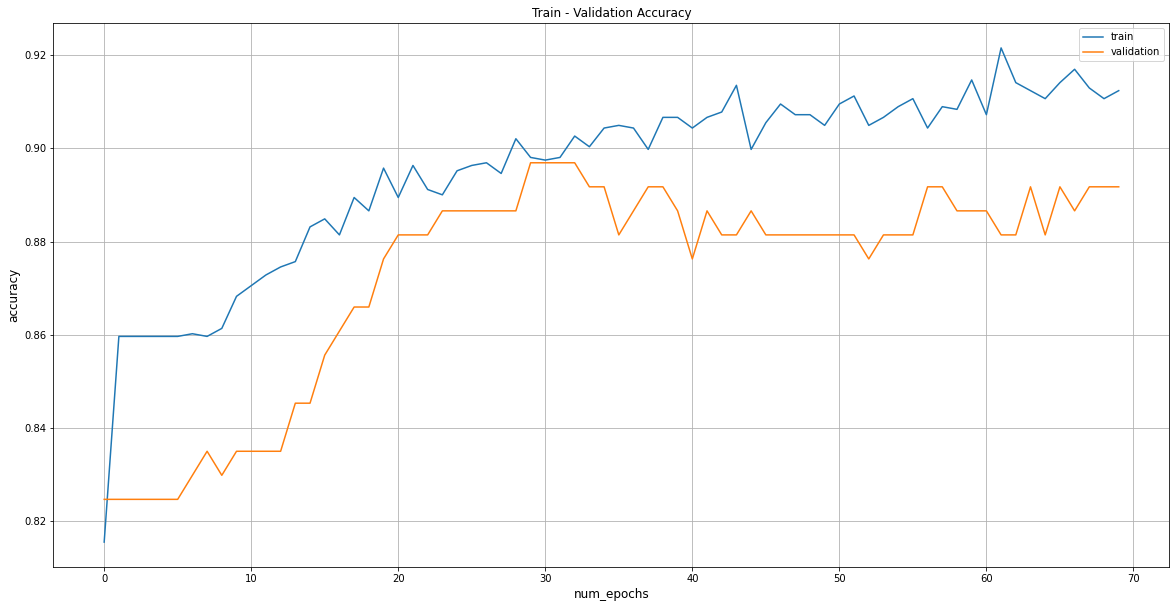

7/7 [==============================] - 5s 716ms/step - loss: 0.2256 - accuracy: 0.9120
Accuracy: 0.9120370149612427


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 7...
Epoch 1/70
55/55 [==============================] - 66s 999ms/step - loss: 0.5120 - accuracy: 0.8385 - val_loss: 0.5199 - val_accuracy: 0.7897
Epoch 2/70
55/55 [==============================] - 51s 923ms/step - loss: 0.4065 - accuracy: 0.8608 - val_loss: 0.5143 - val_accuracy: 0.7897
Epoch 3/70
55/55 [==============================] - 51s 922ms/step - loss: 0.3897 - accuracy: 0.8625 - val_loss: 0.4991 - val_accuracy: 0.7897
Epoch 4/70
55/55 [==============================] - 51s 923ms/step - loss: 0.3738 - accuracy: 0.8625 - val_loss: 0.4775 - val_accuracy: 0.7897
Epoch 5/70
55/55 [==============================] - 51s 923ms/step - loss: 0.3609 - accuracy: 0.8625 - val_loss: 0.4552 - val_accuracy: 0.7897
Epoch 6/70
55/55 [==============================] - 51s 923ms/step - loss: 0.3494 - accuracy: 0.8625 - val_loss: 0.4356 - val_accuracy: 0.7897
Epoch 7/70
55/55 [==============================] - 51s 922ms/step - loss: 0.3381 - accuracy: 0.8625 - val_loss: 0.416

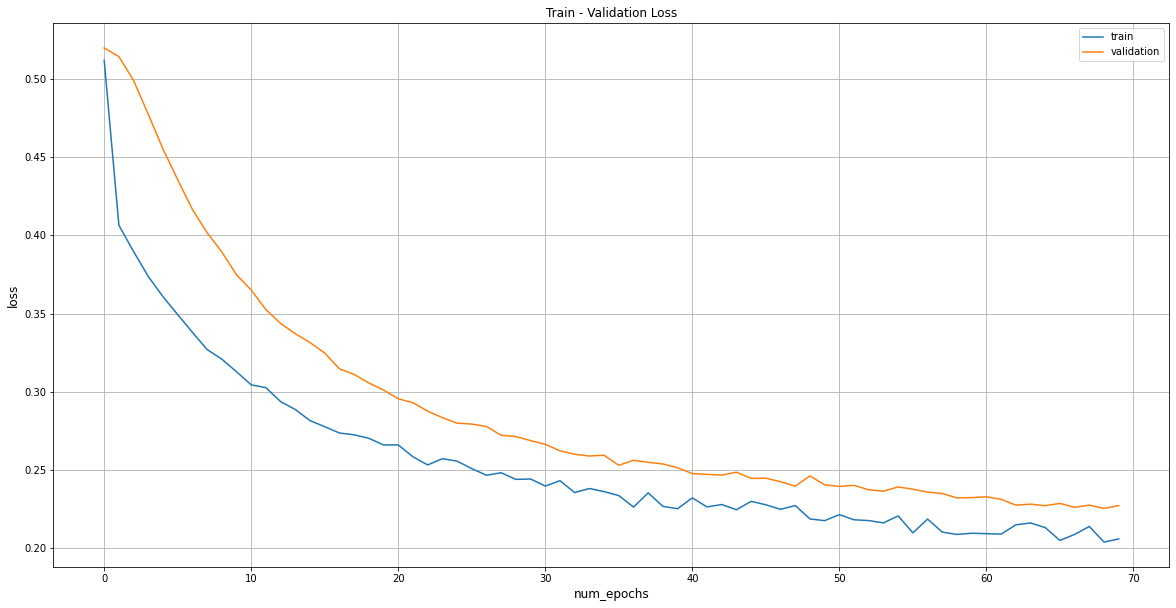

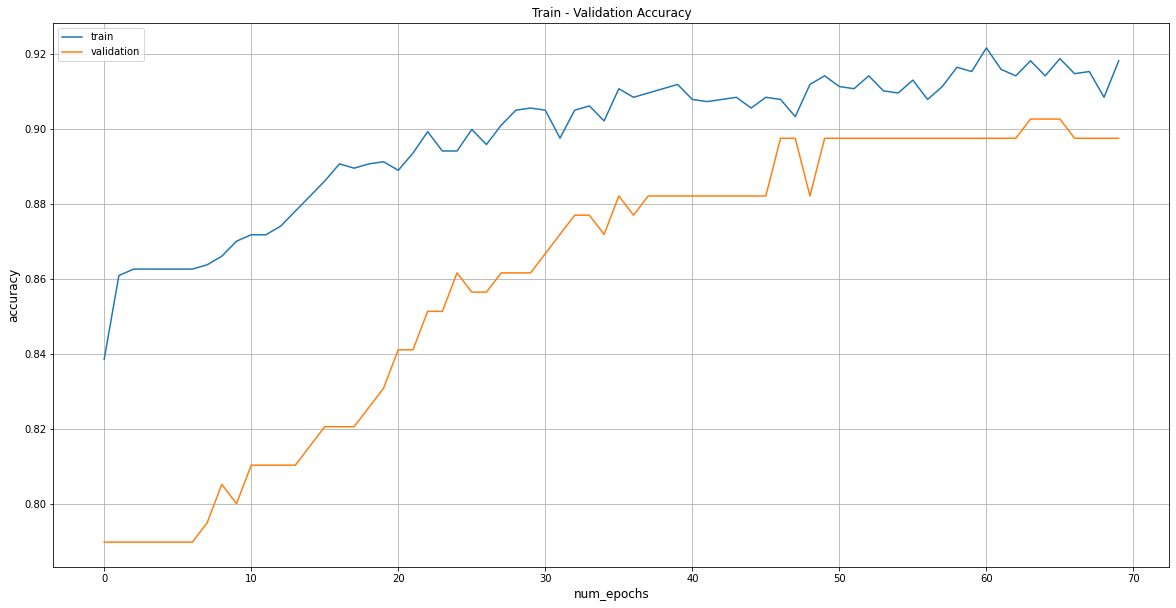

7/7 [==============================] - 5s 710ms/step - loss: 0.2098 - accuracy: 0.9023
Accuracy: 0.9023255705833435


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 8...
Epoch 1/70
55/55 [==============================] - 67s 999ms/step - loss: 0.4897 - accuracy: 0.8603 - val_loss: 0.5076 - val_accuracy: 0.7949
Epoch 2/70
55/55 [==============================] - 51s 923ms/step - loss: 0.3990 - accuracy: 0.8654 - val_loss: 0.4984 - val_accuracy: 0.7949
Epoch 3/70
55/55 [==============================] - 51s 923ms/step - loss: 0.3784 - accuracy: 0.8654 - val_loss: 0.4808 - val_accuracy: 0.7949
Epoch 4/70
55/55 [==============================] - 51s 924ms/step - loss: 0.3666 - accuracy: 0.8654 - val_loss: 0.4605 - val_accuracy: 0.7949
Epoch 5/70
55/55 [==============================] - 51s 924ms/step - loss: 0.3525 - accuracy: 0.8654 - val_loss: 0.4404 - val_accuracy: 0.7949
Epoch 6/70
55/55 [==============================] - 51s 923ms/step - loss: 0.3404 - accuracy: 0.8654 - val_loss: 0.4221 - val_accuracy: 0.7949
Epoch 7/70
55/55 [==============================] - 53s 963ms/step - loss: 0.3311 - accuracy: 0.8671 - val_loss: 0.407

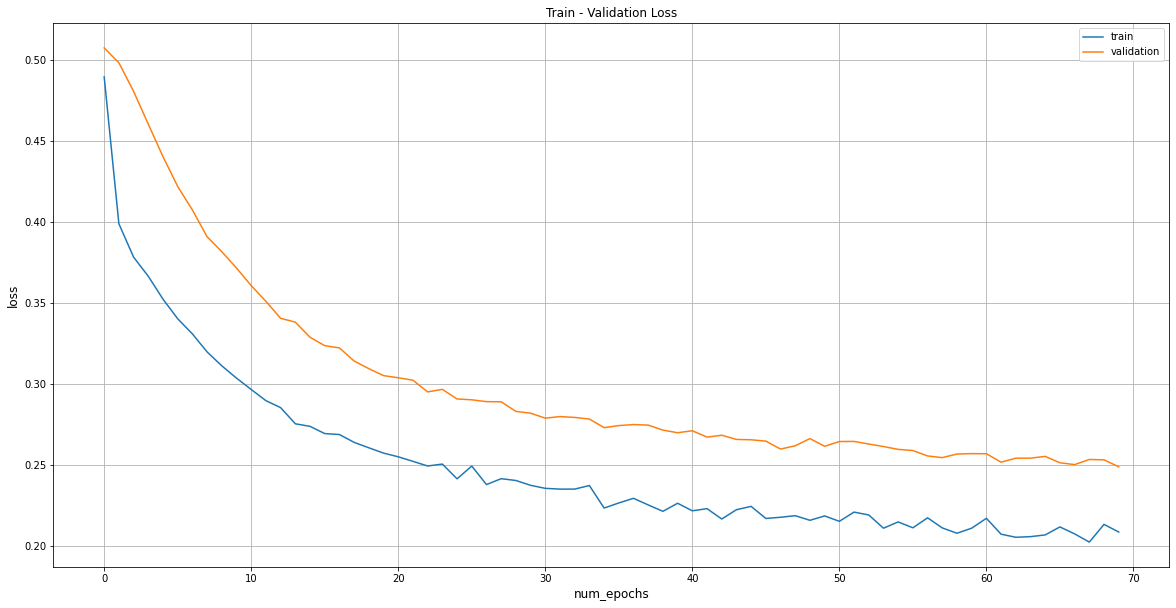

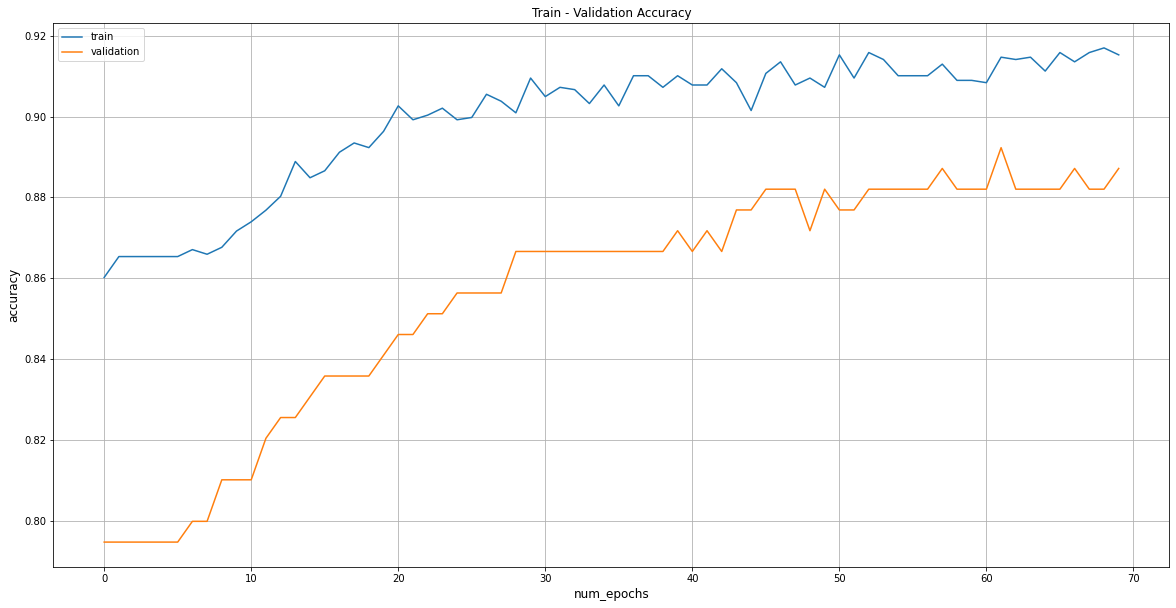

7/7 [==============================] - 5s 709ms/step - loss: 0.2026 - accuracy: 0.9116
Accuracy: 0.9116278886795044


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 9...
Epoch 1/70
55/55 [==============================] - 67s 1s/step - loss: 0.4761 - accuracy: 0.8585 - val_loss: 0.5275 - val_accuracy: 0.7949
Epoch 2/70
55/55 [==============================] - 51s 924ms/step - loss: 0.4143 - accuracy: 0.8603 - val_loss: 0.5104 - val_accuracy: 0.7949
Epoch 3/70
55/55 [==============================] - 51s 924ms/step - loss: 0.3936 - accuracy: 0.8603 - val_loss: 0.4845 - val_accuracy: 0.7949
Epoch 4/70
55/55 [==============================] - 51s 923ms/step - loss: 0.3777 - accuracy: 0.8603 - val_loss: 0.4564 - val_accuracy: 0.7949
Epoch 5/70
55/55 [==============================] - 51s 923ms/step - loss: 0.3626 - accuracy: 0.8603 - val_loss: 0.4349 - val_accuracy: 0.7949
Epoch 6/70
55/55 [==============================] - 51s 923ms/step - loss: 0.3465 - accuracy: 0.8603 - val_loss: 0.4160 - val_accuracy: 0.7949
Epoch 7/70
55/55 [==============================] - 53s 964ms/step - loss: 0.3360 - accuracy: 0.8608 - val_loss: 0.3952 -

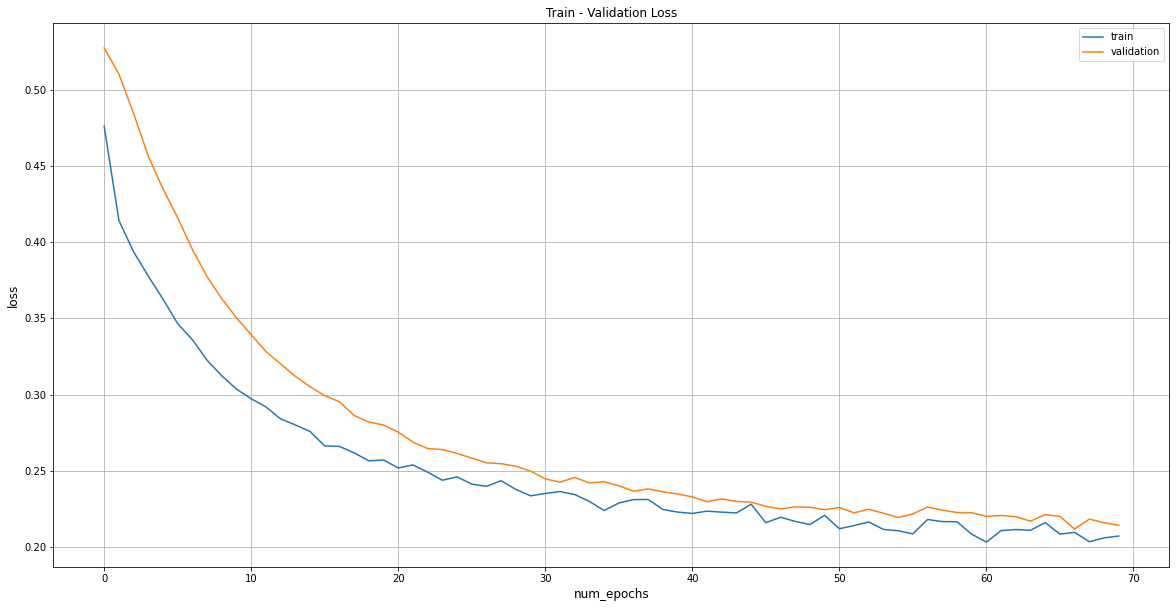

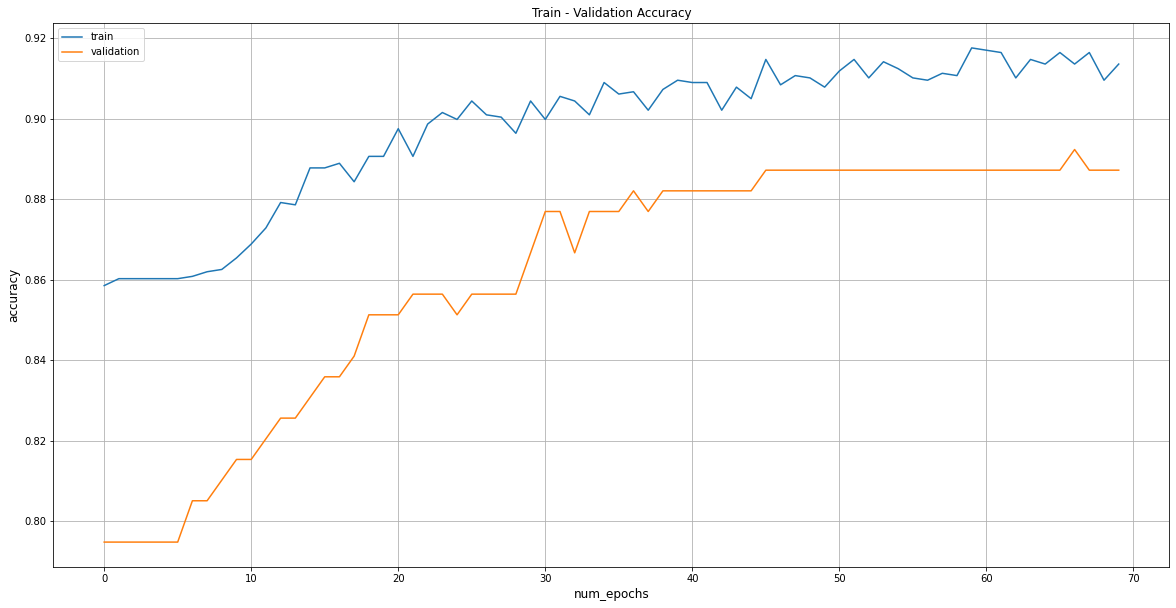

7/7 [==============================] - 5s 709ms/step - loss: 0.2090 - accuracy: 0.9256
Accuracy: 0.9255813956260681


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 10...
Epoch 1/70
55/55 [==============================] - 67s 1s/step - loss: 0.5859 - accuracy: 0.7297 - val_loss: 0.5312 - val_accuracy: 0.7846
Epoch 2/70
55/55 [==============================] - 51s 924ms/step - loss: 0.4231 - accuracy: 0.8608 - val_loss: 0.5161 - val_accuracy: 0.7846
Epoch 3/70
55/55 [==============================] - 51s 923ms/step - loss: 0.3966 - accuracy: 0.8608 - val_loss: 0.5056 - val_accuracy: 0.7846
Epoch 4/70
55/55 [==============================] - 51s 923ms/step - loss: 0.3800 - accuracy: 0.8608 - val_loss: 0.4872 - val_accuracy: 0.7846
Epoch 5/70
55/55 [==============================] - 51s 923ms/step - loss: 0.3668 - accuracy: 0.8608 - val_loss: 0.4693 - val_accuracy: 0.7846
Epoch 6/70
55/55 [==============================] - 51s 923ms/step - loss: 0.3533 - accuracy: 0.8608 - val_loss: 0.4501 - val_accuracy: 0.7846
Epoch 7/70
55/55 [==============================] - 51s 923ms/step - loss: 0.3436 - accuracy: 0.8608 - val_loss: 0.4319 

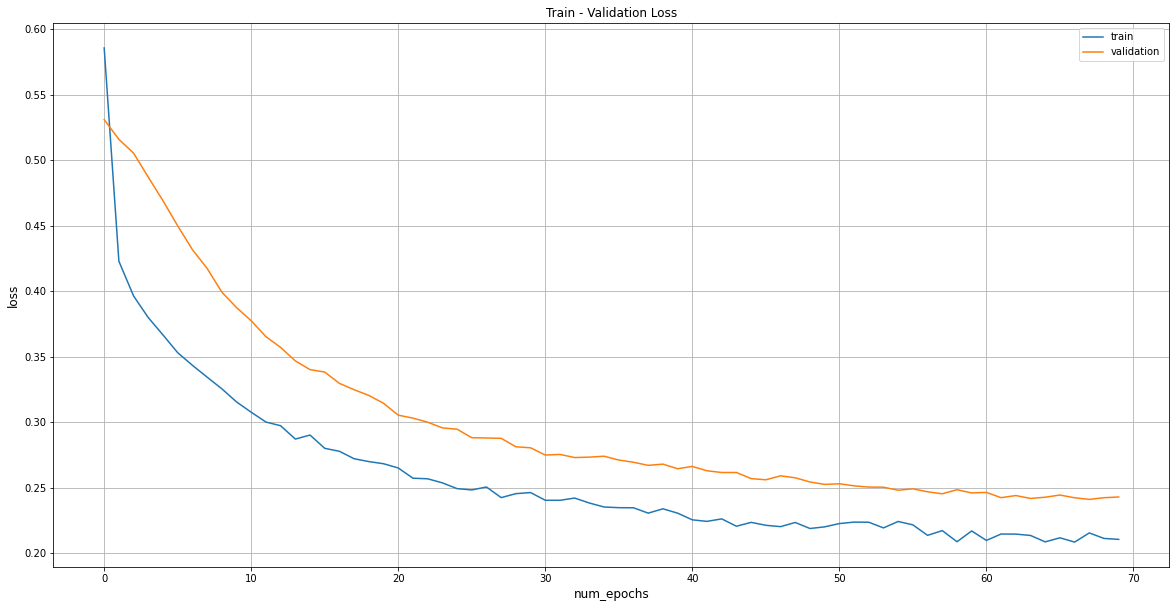

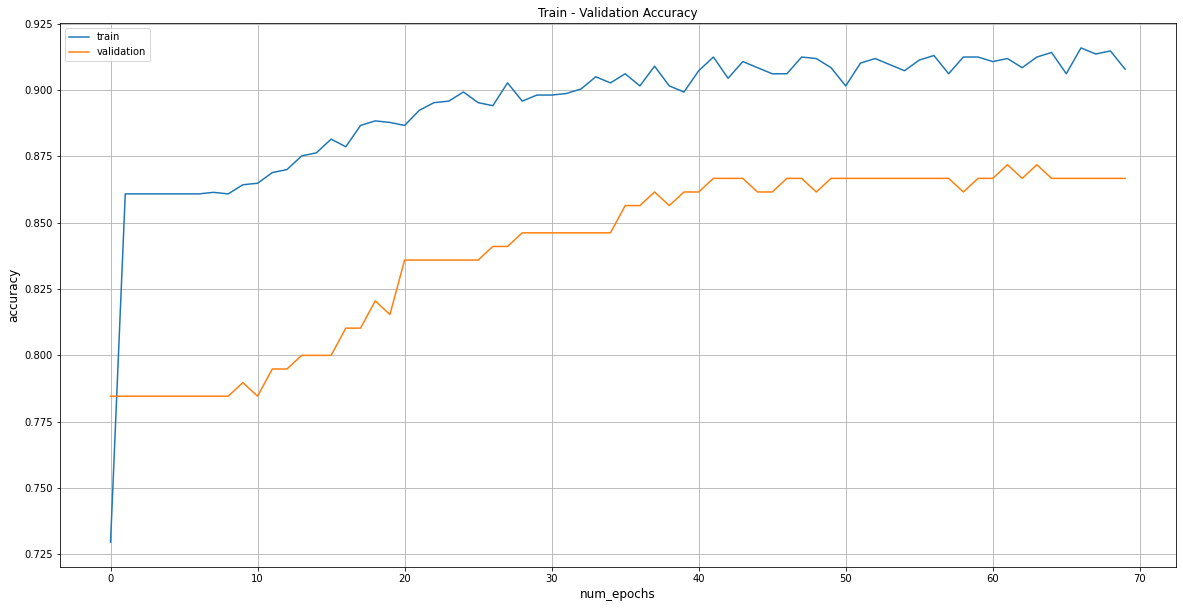

7/7 [==============================] - 5s 710ms/step - loss: 0.1581 - accuracy: 0.9395
Accuracy: 0.9395349025726318


accuracy    0.904944
dtype: float64

In [ ]:
N_EPOCAS = 70
kfold = KFold(n_splits=10, shuffle=True)
acc = []
fold = 1
directory_checkpoint = "tfm/checkpoints/finanzas_tag_s_n/"
for train, test in kfold.split(dataset_labels.body_no_entities):
    
    fold_train_x = dataset_labels.body_no_entities.values[train]
    textos_train = tokenizer(fold_train_x.tolist(), padding="max_length", truncation=True, return_tensors="tf")
     
    fold_train_y = dataset_labels.finanzas_tag_s_n.values[train]
            
    model_checkpoint_callback = ModelCheckpoint(
        filepath=f'{directory_checkpoint}/fold_{fold}',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')
    
    # Para cada Fold se entrena de nuevo
    model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels=N_LABELS)
    model.layers[0].trainable=False
    model.layers[-1].activation=tf.keras.activations.softmax
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    print(f"Starting with Fold {fold}...")

    hist = model.fit(
        textos_train.data,
        fold_train_y,
        validation_split=0.1,
        epochs=N_EPOCAS,
        callbacks=[model_checkpoint_callback, early_stopping]
        )
    
    fold_test_x = dataset_labels.body_no_entities.values[test]
    textos_test = tokenizer(fold_test_x.tolist(), padding="max_length", truncation=True, return_tensors="tf")
    
    fold_test_y = dataset_labels.finanzas_tag_s_n.values[test]

    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Loss")
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Accuracy")
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    model.load_weights(f'{directory_checkpoint}/fold_{fold}')
    i_acc  = model.evaluate(textos_test.data, fold_test_y)
    print("Accuracy:", i_acc[1])
    acc.append(i_acc[1])
    
    fold += 1
result = pd.DataFrame({'accuracy':acc})
result.mean()

In [ ]:
result

,accuracy
0,0.902778
1,0.921296
2,0.875000
3,0.875000
4,0.884259
5,0.912037
6,0.902326
7,0.911628
8,0.925581
9,0.939535


In [ ]:
result.mean()

accuracy    0.904944
dtype: float64